# Install package

In [ ]:
%%capture
!pip install segmentation-models-pytorch lightning albumentations

# Loading data
 - train images + segmentation masks
 - validation images + segmentation masks
 - test images + segmentation masks


In [ ]:
import os
import cv2

import torch
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
import pytorch_lightning as pl

In [ ]:
DATA_DIR = "./data/CamVid/"
# x = image, y = mask
x_train_dir = os.path.join(DATA_DIR, "train")
y_train_dir = os.path.join(DATA_DIR, "trainannot")

x_valid_dir = os.path.join(DATA_DIR, "val")
y_valid_dir = os.path.join(DATA_DIR, "valannot")

x_test_dir = os.path.join(DATA_DIR, "test")
y_test_dir = os.path.join(DATA_DIR, "testannot")

# Dataloader
Writing helper class for data extraction, tranformation and preprocessing
https://pytorch.org/docs/stable/data

In [ ]:
class Dataset(BaseDataset):
    """
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
    """

    CLASSES = [
        "wire",
        "background",
    ]

    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        #self.masks_fps = [os.path.join(masks_dir, image_id.replace(".bmp", "_lab.bmp")) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation

    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        # BGR-->RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0) # check mask = gray

        # 只提取一個類別，轉為單通道 binary mask (H, W)
        target_class_value = self.class_values[0]
        mask = (mask == target_class_value).astype("uint8")

        # 可支援 Albumentations 的 image / mask 同步處理，不等於執行augmentation
        if self.augmentation:
            augmented  = self.augmentation(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        return image, mask

    def __len__(self):
        return len(self.ids)

In [ ]:
# helper function for data visualization
# Visualize image, mask, and prediction side by side to verify alignment, augmentation, and accuracy.

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        if name == "image":
            plt.imshow(image.transpose(1, 2, 0))
        else:
            plt.imshow(image)
    plt.show()

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes=["wire"])
# get some sample
image, mask = dataset[0]
visualize(
    image=image,
    wire_mask=mask.squeeze(),
)

# Augmentations

Apply a large number of different augmentations:
 - Horizontal Flip
 - Shift Scale Rotate
 - Random Brightness Contrast
 - Hue Saturation Value
 - Sharpen
 - Gaussian Blur
 - random crops


In [ ]:
# training set images augmentation for wire bond segmentation
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),  # 模擬左右反射
        A.ShiftScaleRotate(
            shift_limit=0.02, scale_limit=0.1, rotate_limit=5, p=0.5, border_mode=0
        ),  # 微幅移動與縮放，保護結構細節

        A.RandomBrightnessContrast(p=0.3),
        A.HueSaturationValue(p=0.3),  # 模擬拍攝光源與色差變化
        A.Sharpen(p=0.2),             # 強化金線邊界
        A.GaussianBlur(p=0.2),        # 偶爾模糊模擬對焦偏移

        A.PadIfNeeded(min_height=256, min_width=256, always_apply=True),
        A.RandomCrop(height=256, width=256, always_apply=True),
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(256, 256),
    ]
    return A.Compose(test_transform)

In [ ]:
# Visualize resulted augmented images and masks
augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=["wire"],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[3]
    visualize(image=image, mask=mask.squeeze())

In [ ]:
#"Synchronously crop the image and mask, and filter patches based on the proportion of gold wire pixels.
#Assume that mask value 0 = gold wire, and 1 = background."

In [ ]:
class DynamicPatchDataset(Dataset):
    def __init__(self, image, mask, patch_size=256, stride=128, min_wire_ratio=0.01, transform=None):
        """
        Args:
            image (np.ndarray): 單張原始影像 (H, W, C)
            mask (np.ndarray): 對應 segmentation mask (H, W)，wire=0, background=1
            patch_size (int): 要裁切的 patch 大小（長寬相等）
            stride (int): 滑動步長
            min_wire_ratio (float): 0~1，最少金線像素比例
            transform (callable, optional): 可選的影像增強函式（image, mask 同步變換）
        """
        assert image.shape[:2] == mask.shape[:2], "影像與 mask 尺寸不一致！"

        self.image = image
        self.mask = mask
        self.patch_size = patch_size
        self.stride = stride
        self.min_wire_ratio = min_wire_ratio
        self.transform = transform if transform is not None else self._use_transform()
        self.locations = self._extract_locations()

        self.patch_imgs, self.patch_masks = self._extract_valid_patches()

    def _use_transform(self):
            return A.Compose([
                A.HorizontalFlip(p=0.5),  # 模擬左右反射
                A.ShiftScaleRotate(
                    shift_limit=0.02, scale_limit=0.1, rotate_limit=5, p=0.5, border_mode=0
                ),  # 微幅移動與縮放，保護結構細節

                A.RandomBrightnessContrast(p=0.3),
                A.HueSaturationValue(p=0.3),  # 模擬拍攝光源與色差變化
                A.Sharpen(p=0.2),             # 強化金線邊界
                A.GaussianBlur(p=0.2),        # 偶爾模糊模擬對焦偏移
                A.PadIfNeeded(min_height=256, min_width=256, always_apply=True),
                A.RandomCrop(height=256, width=256, always_apply=True),

                A.Normalize(),  # 如果 encoder 有預訓練權重，可加上 mean/std 參數
                ToTensorV2()    #讓 Albumentations 輸出 PyTorch 格式供模型輸入
            ])

    def _extract_locations(self):
        h, w = self.image.shape[:2]
        patch_imgs, patch_masks, patch_locs = [], [], []

        # Padding 避免尺寸不足
        pad_h = max(0, self.patch_size - h)
        pad_w = max(0, self.patch_size - w)
        top, bottom = pad_h // 2, pad_h - pad_h // 2
        left, right = pad_w // 2, pad_w - pad_w // 2

        img = cv2.copyMakeBorder(self.image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=1)
        msk = cv2.copyMakeBorder(self.mask, top, bottom, left, right, cv2.BORDER_CONSTANT, value=1)

        h, w = img.shape[:2]

        # 根據形狀裁切方向
        if w >= h:
            # 水平滑動
            for x in range(0, w - self.patch_size + 1, self.stride):
                img_patch = img[0:self.patch_size, x:x + self.patch_size]
                msk_patch = msk[0:self.patch_size, x:x + self.patch_size]
                if np.sum(msk_patch == 0) / (self.patch_size ** 2) >= self.min_wire_ratio:
                    patch_imgs.append(img_patch)
                    patch_masks.append(msk_patch)
                    patch_locs.append((y, x))
        else:
            # 垂直滑動
            for y in range(0, h - self.patch_size + 1, self.stride):
                img_patch = img[y:y + self.patch_size, 0:self.patch_size]
                msk_patch = msk[y:y + self.patch_size, 0:self.patch_size]
                if np.sum(msk_patch == 0) / (self.patch_size ** 2) >= self.min_wire_ratio:
                    patch_imgs.append(img_patch)
                    patch_masks.append(msk_patch)
                    patch_locs.append((y, x))

        return patch_imgs, patch_masks, patch_locs

    def __len__(self):
        return len(self.patch_imgs)

    def __getitem__(self, idx):
        image = self.patch_imgs[idx]
        mask = self.patch_masks[idx]
        location = self.locations[idx]

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask, location

# dataset = DynamicPatchDataset(
#     image=image,
#     mask=mask,
#     patch_size=256,
#     stride=128,
#     min_wire_ratio=0.01,
#     transform=None  # 你可放 Albumentations transform
# )
# loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
CLASSES = ["wire"]

train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    classes=CLASSES,
)

test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=24, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=24, shuffle=False, num_workers=4)

# Create model and train

In [11]:
# Some training hyperparameters
EPOCHS = 20
T_MAX = EPOCHS * len(train_loader)
OUT_CLASSES = 1

In [12]:
class CamVidModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [ ]:
model = CamVidModel("UnetPlusPlus", "resnet34", in_channels=3, out_classes=OUT_CLASSES)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 127MB/s] 


# Training

In [14]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Validation and test metrics

In [15]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_loader, verbose=False)
print(valid_metrics)

Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_per_image_iou': 0.679887056350708, 'valid_dataset_iou': 0.8300998210906982}]


In [16]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
print(test_metrics)

Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.6644061803817749, 'test_dataset_iou': 0.7999382615089417}]


# Result visualization

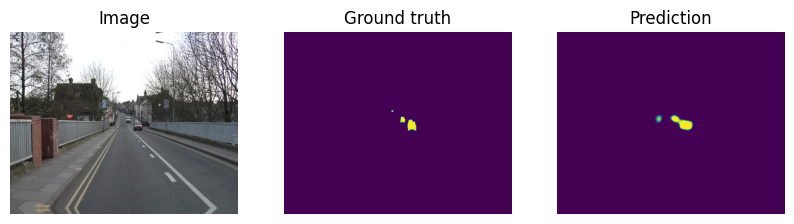

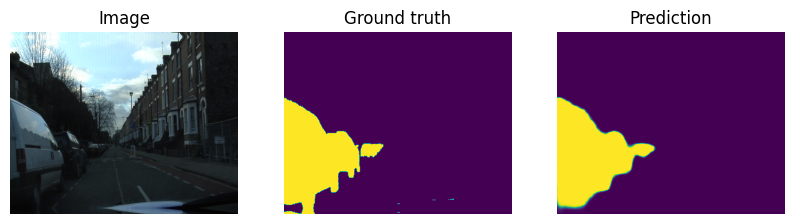

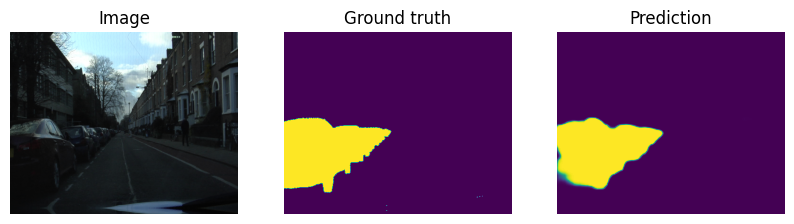

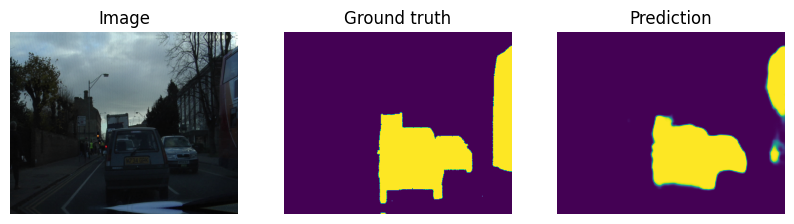

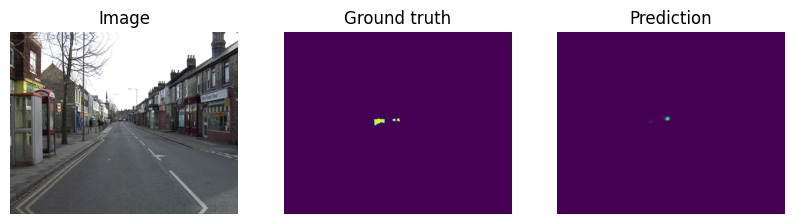

In [17]:
images, masks = next(iter(test_loader))
with torch.inference_mode():
    model.eval()
    logits = model(images)
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    # Number of samples visualized
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break